# Assignment 2 - Computational Machine Learning
<b>Group Details</b> - <br>
Kunjar Supriya Rao - S3860925 <br>
Yeshaswi Aralaguppe Muralidhar - S3825856 <br>

## Research Goal
Image classification of European road traffic signs. <br>
The aim is to build and train a machine learning model to classify 28x28 gray-scale images according to - <br>
1) <b>Sign-shape </b> - diamond, hex, round, square, triangle<br>
2) <b>Sign-type </b> - stop, parking, giveway etc.

## Import the necessary libraries

In [355]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import tensorflow_addons as tfa
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import pandas as pd
import glob
import keras
import warnings #hide deprecation warnings
from sklearn.model_selection import train_test_split #to split data into train and validation data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Read the data

Since the task involves labelling images, its a classification problem. <br>
To read the given training data, we explore the folder structure and retrieve the labels and image names. Further, we convert all the images into grey scale and reshape it (28x28 size images). The pixel values are written out to a csv file. The image path, sign shape, sign type and flattened pixel array are read in as a pandas dataframe.

In [356]:
import zipfile
with zipfile.ZipFile('./trafficsigns_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [357]:
# Reference - https://stackoverflow.com/questions/49070242/converting-images-to-csv-file-in-python

warnings.filterwarnings('ignore') #ignore deprecation warnings

image_list = []
for filepath in glob.glob('./trafficsigns_dataset/*/*/*.png', recursive=True): #Loop through all folders
    filename = filepath.split("\\")[-1]
    sign_type = filepath.split("\\")[-2]    
    sign_shape = filepath.split("\\")[-3]

    img_file = Image.open(filepath)

    # get original image parameters
    width, height = img_file.size
    format = img_file.format
    mode = img_file.mode

    # Make image Greyscale
    img_grey = img_file.convert('L')

    # Save Greyscale values
    value = np.asarray(img_grey.getdata(), dtype=np.int).reshape((img_grey.size[1], img_grey.size[0]))
    value = value.flatten()
    with open("img_pixels.csv", 'a') as f:
        writer = csv.writer(f)
        writer.writerow(value)
    
    image_list.append((filepath, sign_shape, sign_type, value))

# Create a data frame
data = pd.DataFrame(data=image_list, columns=['image_path', 'sign_shape', 'sign_type', 'flattened array'])

Lets take a look at the dataframe

In [358]:
data.sample(5) #Show random 5 observations

,image_path,sign_shape,sign_type,flattened array
2310,./trafficsigns_dataset\square\crossing\00661_0...,square,crossing,"[68, 65, 63, 61, 58, 58, 56, 57, 60, 47, 51, 7..."
216,./trafficsigns_dataset\diamond\rightofway\0171...,diamond,rightofway,"[27, 25, 22, 21, 19, 22, 30, 35, 29, 27, 29, 2..."
81,./trafficsigns_dataset\diamond\rightofway\0093...,diamond,rightofway,"[31, 31, 32, 31, 30, 31, 34, 36, 32, 35, 46, 5..."
586,./trafficsigns_dataset\round\bicycle\01849_000...,round,bicycle,"[12, 11, 12, 11, 10, 11, 9, 9, 14, 31, 42, 65,..."
3559,./trafficsigns_dataset\triangle\warning\01530_...,triangle,warning,"[17, 21, 23, 22, 18, 17, 12, 9, 9, 9, 10, 9, 1..."


In [359]:
data.shape

(3699, 4)

In [360]:
print(data['flattened array'][0].shape)
print(data['flattened array'][345].shape)

(784,)
(784,)


Check for any null values

In [361]:
print(data['sign_shape'].value_counts())
print(data['sign_shape'].value_counts().count())

round       1760
triangle     926
square       688
diamond      282
hex           43
Name: sign_shape, dtype: int64
5


In [362]:
print(data['sign_type'].value_counts())
print(data['sign_type'].value_counts().count())

warning             695
noentry             375
speed               316
bicycle             285
rightofway          282
parking             276
noparking           242
giveway             231
continue            199
trafficdirective    195
limitedtraffic      125
traveldirection     124
laneend             118
roundabout           98
crossing             95
stop                 43
Name: sign_type, dtype: int64
16


In [363]:
pd.isna(data).sum()

image_path         0
sign_shape         0
sign_type          0
flattened array    0
dtype: int64

<b>Observations:</b> <br>
1) We have 3699 images in our data set <br>
2) All images are scaled to 28x28 size images, and flattened array is a row vector of length 784 (28*28)<br>
3) We have 5 sign shapes - round, triangle, square, diamond and hex <br>
4) There are 16 sign types <br>
5) No null values <br>

## Exploratory Data Analysis

We plot a histogram to check the distribution of the data and check the frequencies.

In [364]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_path       3699 non-null   object
 1   sign_shape       3699 non-null   object
 2   sign_type        3699 non-null   object
 3   flattened array  3699 non-null   object
dtypes: object(4)
memory usage: 115.7+ KB


Text(0, 0.5, 'Count')

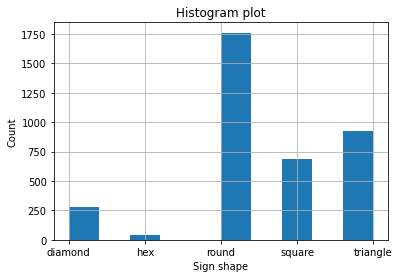

In [384]:
data.sign_shape.hist()
plt.title("Histogram plot")
plt.xlabel('Sign shape')
plt.ylabel('Count')

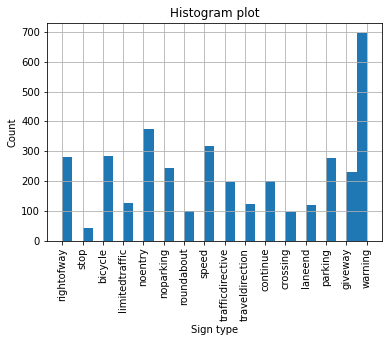

In [385]:
data.sign_type.hist(bins=30)
plt.xticks(rotation='vertical')
plt.title("Histogram plot")
plt.xlabel('Sign type')
plt.ylabel('Count')
plt.show()

Lets randomnly, plot 4 images

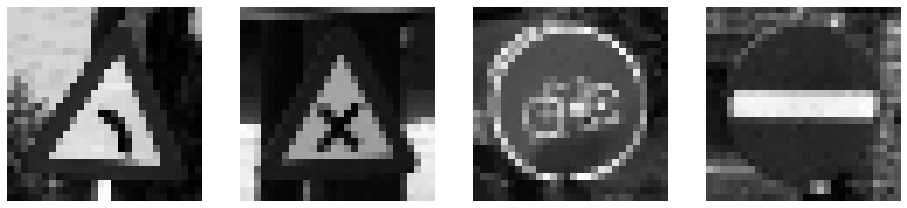

In [367]:
r_inx = np.random.choice(3699, 4)
rand_data = data.loc[r_inx,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

<b>Observations:</b> <br>
1) The dataset is highly imbalanced as observed from the histogram plots <br>
2) The training samples for the sign shape category 'hex' is very less when compared to other classes. <br>
3) The training samples for the sign type categories -stop, laneend, crossing, traveldirection, limitedtraffic and roundabout are relatively very less when compared to other classes. <br>
3) Successfully retrieved grey scale images.

## Image encoding
For later processing we map the string labels to numeric values.

In [368]:
d1 = {'rightofway':0, 'stop':1, 'bicycle':2, 'limitedtraffic':3, 'noentry':4, 'noparking':5, 'roundabout':6, 'speed':7, 'trafficdirective':8, 'traveldirection':9,  'continue':10, 'crossing':11, 'laneend':12, 'parking':13, 'giveway':14, 'warning':15}
data['sign_type_num'] = data['sign_type'].map(d1, na_action='ignore')

In [369]:
d2 = {'diamond':0, 'hex':1, 'square':2, 'triangle':3, 'round':4}
data['sign_shape_num'] = data['sign_shape'].map(d2, na_action='ignore')

In [370]:
data.dtypes

image_path         object
sign_shape         object
sign_type          object
flattened array    object
sign_type_num       int64
sign_shape_num      int64
dtype: object

## Model development 
The given problem falls under the supervised learning technique, and is an image classification problem.
Next, we explore the evaluation/performance metrics and build the model.

### Evaluation metrics

In our case, model accuracy might not be a good evaluation metric as the dataset is imbalanced and might lead to poor performance through wrong inferences.

Hence, we choose f1 score, which is the harmonic mean of recall and precision, to get an idea of how well our model performs.
Further, for this task, we will use **f1_score** as the performance measure since
 - its an imbalanced dataset and the target class is heavily biased for few classes.
 - we would like to give equal importance to all the classes and see similar performance.


In [371]:
x=pd.read_csv("img_pixels.csv", header=None)

In [372]:
y=data['sign_shape_num']

### Base Model 1
To start off, we use a multiclass logistic regression model, to see how it performs on the dataset. As logistic regression is easy to implement we have chosen this model as the first model and evaluated its performance.<br>

#### Setting up the experiment
1) We try to clasify the traffic images based on the shape using logistic regression
2) We use the stratify parameter, to split all the classes proportionally between the train and  validation dataset <br>
3) Since its an imbalanced dataset, we add another parameter class weight to have the value 'balanced'.
4) Next we try to classify the traffic images based on the sign type using logistic regression.


#### Classification of sign shape

In [373]:
x_train, x_val, y_train, y_val = train_test_split(x,y,random_state=0, stratify=data['sign_shape_num'])
clf=LogisticRegression(class_weight='balanced')
fit=clf.fit(x_train,y_train)
pred=fit.predict(x_val)
confusion_matrix(y_val, pred)

array([[ 65,   0,   1,   1,   3],
       [  0,   9,   0,   0,   2],
       [  0,   0, 162,   5,   5],
       [  1,   0,   5, 214,  12],
       [  4,   0,   7,   6, 423]], dtype=int64)

In [374]:
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        70
           1       1.00      0.82      0.90        11
           2       0.93      0.94      0.93       172
           3       0.95      0.92      0.93       232
           4       0.95      0.96      0.96       440

    accuracy                           0.94       925
   macro avg       0.95      0.91      0.93       925
weighted avg       0.94      0.94      0.94       925



From the classification report it can be inferred that the logistic regression model provides high f1 score having high probabilty for all the classes to be correctly classified.

In [375]:
def get_f1_scores(clf, train_X, train_y, val_X, val_y):
    train_pred = clf.predict(train_X)
    val_pred = clf.predict(val_X)

    train_f1 = f1_score(train_y, train_pred, average='macro')
    val_f1 = f1_score(val_y, val_pred, average='macro')

    return train_f1, val_f1

In [376]:
train_f1, val_f1 = get_f1_scores(clf, x_train, y_train, x_val, y_val)
print("Training F1 score - ",train_f1)
print("Validation F1 score - ",val_f1)

Training F1 score -  1.0
Validation F1 score -  0.9305438055611732


The training f1 score of the model is 100%. The validation F1 score is lesser than the training f1 score and this gap indicates that the model is overfitting. Therefore to fix this we apply regularisation technique

#### Ridge Regularisation

In [347]:
lambda_paras = np.logspace(-5, 2, num=25)  # Providing range of values to select the best lambda value

train_performace = list()
valid_performace = list()

for lambda_para in lambda_paras:
    clf = LogisticRegression(penalty='l2', C = 1.0/lambda_para, 
                             random_state=0, solver='liblinear', max_iter=1000 , 
                             class_weight='balanced').fit(x_train, y_train.ravel())
    
    train_f1, val_f1 = get_f1_scores(clf, x_train, y_train, x_val, y_val)
    
    train_performace.append(train_f1)
    valid_performace.append(val_f1)

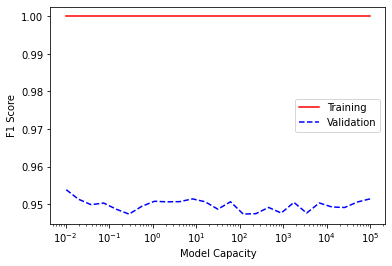

In [348]:
plt.plot([1.0/lambda_para for lambda_para in lambda_paras], 
         [tp for tp in train_performace], 'r-')
plt.plot([1.0/lambda_para for lambda_para in lambda_paras], 
         [vp for vp in valid_performace], 'b--')
plt.xscale("log")
plt.ylabel('F1 Score')
plt.xlabel('Model Capacity')
plt.legend(['Training','Validation'])
plt.show()

Again the gap in training and validation scores indicate overfitting even upon regularisation

#### Classification for sign_type
We repeat the similar method for classifying the sign-type

In [377]:
y=data['sign_type_num']

In [378]:
x_train, x_val, y_train, y_val = train_test_split(x,y,random_state=0, stratify=data['sign_type_num'])

In [379]:
fit=clf.fit(x_train,y_train)
pred=fit.predict(x_val)
confusion_matrix(y_val, pred)

array([[ 66,   0,   0,   0,   3,   1,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,  10,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,  70,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   1,  26,   0,   1,   0,   1,   0,   0,   0,   0,   0,
          0,   0,   2],
       [  2,   0,   0,   0,  88,   3,   0,   0,   0,   1,   0,   0,   0,
          0,   0,   0],
       [  1,   0,   0,   0,   1,  53,   0,   0,   0,   0,   0,   0,   1,
          0,   0,   4],
       [  0,   0,   0,   0,   0,   0,  24,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   1,   0,   0,   1,  75,   1,   0,   0,   0,   0,
          1,   0,   0],
       [  0,   0,   0,   2,   0,   0,   0,   1,  46,   0,   0,   0,   0,
          0,   0,   0],
       [  1,   0,   0,   0,   2,   0,   0,   0,   0,  26,   2,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   

In [380]:
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        71
           1       1.00      0.91      0.95        11
           2       0.99      0.99      0.99        71
           3       0.90      0.84      0.87        31
           4       0.90      0.94      0.92        94
           5       0.85      0.88      0.87        60
           6       0.92      1.00      0.96        24
           7       0.97      0.95      0.96        79
           8       0.98      0.94      0.96        49
           9       0.96      0.84      0.90        31
          10       0.96      0.98      0.97        50
          11       0.96      0.96      0.96        24
          12       0.97      1.00      0.98        29
          13       0.97      0.99      0.98        69
          14       0.98      0.98      0.98        58
          15       0.96      0.96      0.96       174

    accuracy                           0.95       925
   macro avg       0.95   

In [381]:
train_f1, val_f1 = get_f1_scores(clf, x_train, y_train, x_val, y_val)
print("Training F1 score - ",train_f1)
print("Validation F1 score - ",val_f1)

Training F1 score -  1.0
Validation F1 score -  0.9455694021125031


From the above output it is evident that the model is clearly over fitting. Therefore implementing regularisation technique

In [382]:
lambda_paras = np.logspace(-5, 2, num=25)    #establish the lambda values to test (grid)

# Perform the search
train_performace = list()
valid_performace = list()

for lambda_para in lambda_paras:
    clf = LogisticRegression(penalty='l2', C = 1.0/lambda_para, 
                             random_state=0, solver='liblinear', max_iter=1000 , 
                             class_weight='balanced').fit(x_train, y_train.ravel())
    
    train_f1, val_f1 = get_f1_scores(clf, x_train, y_train, x_val, y_val)
    
    train_performace.append(train_f1)
    valid_performace.append(val_f1)

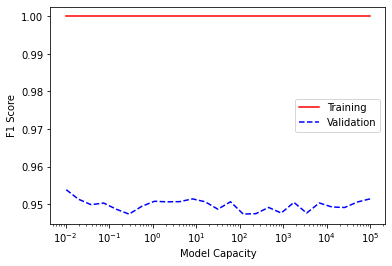

In [383]:
plt.plot([1.0/lambda_para for lambda_para in lambda_paras], 
         [tp for tp in train_performace], 'r-')
plt.plot([1.0/lambda_para for lambda_para in lambda_paras], 
         [vp for vp in valid_performace], 'b--')
plt.xscale("log")
plt.ylabel('F1 Score')
plt.xlabel('Model Capacity')
plt.legend(['Training','Validation'])
plt.show()

We observe that the problem of overfitting exits, even after applying regularisation technique in both the classification problems and hence choose to explore other models

On a side note, Logistic Regression is a very simple model and usually less applicable to real world scenarios. Most of the image classification problems make use of neural networks and other deep learning models, therefore we proceed to explore these complex models and evaluate their performance. 

## Base Model 2
We choose a Multi Layer Perceptron (MLP) as our base model. MLP utilizes a supervised learning technique called backpropagation for training. Its multiple layers and non-linear activation distinguish MLP from a linear perceptron. It can distinguish data that is not linearly separable like our traffic sign data.

Having a single layer will make the model learn very less and that is why we choose to explore MLP. In this network let’s set the hidden layer dimension to 256. This is a hyper parameter and we can tune it later.

#### Classification of Sign - Shape

#### Setting the experiment 
1) The traffic sign data is divided into train and validation split and we perform a 80:20 split of train and validation data using train_test_split module from the sklearn library <br>
2) Further, the stratify parameter ensures that all classes are split proportionately <br>
3) The model will be evaluated on real world dataset, gathered through google images

#### Distribution of train and validation data using histograms

In [388]:
train_x, val_x, train_y, val_y = train_test_split(data['image_path'], data['sign_shape_num'], test_size=0.2, stratify=data['sign_shape_num'])

In [389]:
train_x.shape

(2959,)

In [390]:
val_x.shape

(740,)

In [391]:
train_y.shape

(2959,)

In [392]:
val_y.shape

(740,)

Text(0, 0.5, 'Count')

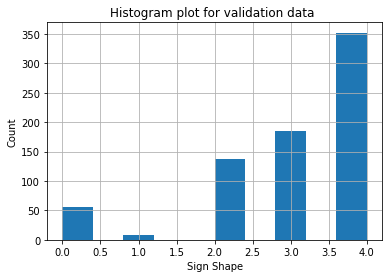

In [393]:
val_y.hist()
plt.title("Histogram plot for validation data ")
plt.xlabel('Sign Shape')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

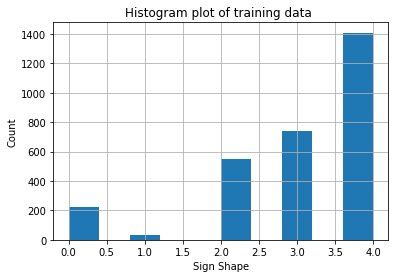

In [394]:
train_y.hist()
plt.title("Histogram plot of training data ")
plt.xlabel('Sign Shape')
plt.ylabel('Count')

Here we define a function for plotting the learning rates for the training and validation data. 

In [395]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')    
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')  
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

We set the below parameters for our Neural network model. Based on the performance(overfit/underfit) we will tune the number of hidden layers.

In [396]:
INPUT_DIM = (28,28,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 5

For easier implementation and understanding we chose the `Sequential` model 

In [397]:
warnings.filterwarnings('ignore')
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [398]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 2352)              0         
                                                                 
 dense_24 (Dense)            (None, 256)               602368    
                                                                 
 dense_25 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 603,653
Trainable params: 603,653
Non-trainable params: 0
_________________________________________________________________


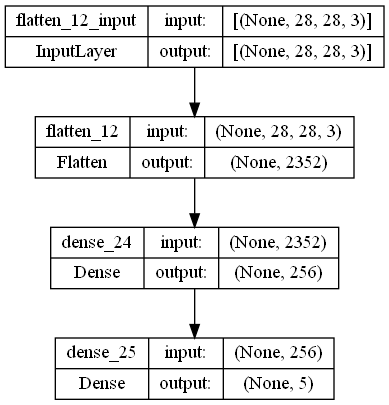

In [399]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [400]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=[tfa.metrics.F1Score(num_classes=5), tf.keras.metrics.AUC(from_logits=True) ])

#### Parameters used above: <br>
Optimizer: We have selected `SGD` as our optimizer. Even though `Adam` converges faster, SGD generalizes better than Adam and thus results in improved final performance. Addiotnally it is computationally much less expensive than typical Gradient Descent. 

Loss: We have selected `CategoricalCrossentropy` as our loss function because this is used in multi-class classification tasks. These are tasks where an example can only belong to one out of many possible categories, and the model must decide which one. 

Metrics: We chose to use the area under the convex hull of the ROC curve (`AUC`) as our evaluation metric because it is frequently used for imbalanced classification problems and considers the full ROC curve (Receiver Operator Characteristic) curve to evaluate performance. Additionally as stated earlier, we are using the `F1` score for our evaluation metric.

In [401]:
# train_df = pd.DataFrame(data=train_data, columns=['image_path', 'label'])
train_df = pd.DataFrame()
train_df['image_path']=train_x.to_frame()
train_df['sign_shape_num']=train_y.to_frame()

In [402]:
train_df.head()

,image_path,sign_shape_num
478,./trafficsigns_dataset\round\bicycle\00822_000...,4
1160,./trafficsigns_dataset\round\noparking\00765_0...,4
2913,./trafficsigns_dataset\triangle\giveway\01205_...,3
1050,./trafficsigns_dataset\round\noentry\01546_000...,4
122,./trafficsigns_dataset\diamond\rightofway\0111...,0


In [403]:
val_df = pd.DataFrame()
val_df['image_path']=val_x.to_frame()
val_df['sign_shape_num']=val_y.to_frame()

In [404]:
val_df.head()

,image_path,sign_shape_num
1355,./trafficsigns_dataset\round\roundabout\00100_...,4
3237,./trafficsigns_dataset\triangle\warning\00408_...,3
534,./trafficsigns_dataset\round\bicycle\01342_000...,4
2018,./trafficsigns_dataset\round\traveldirection\0...,4
1156,./trafficsigns_dataset\round\noparking\00744_0...,4


In [57]:
# train_df.to_csv('TrainData.csv')
# val_df.to_csv('ValData.csv')

In [405]:
train_df['sign_shape_num']=train_df['sign_shape_num'].astype(str)
val_df['sign_shape_num']=val_df['sign_shape_num'].astype(str)

In [406]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def calculate_generators(train_df, val_df, col_x, col_y):
    
    train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
    val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

    batch_size = 32

    train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_df,
            directory='./',
            x_col= col_x,
            y_col= col_y,
            target_size=(28, 28),
            batch_size=batch_size,
            class_mode='categorical')

    validation_generator = val_datagen.flow_from_dataframe(
            dataframe=val_df,
            directory='./',
            x_col= col_x,
            y_col= col_y,
            target_size=(28, 28),
            batch_size=batch_size,
            class_mode='categorical')
    
    return train_generator,validation_generator

In [407]:
train_generator,validation_generator = calculate_generators(train_df, val_df, 'image_path', 'sign_shape_num')

Found 2959 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


In [408]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)

Epoch 1/50
93/93 [==============================] - 37s 365ms/step - loss: 1.2234 - f1_score: 0.1555 - auc_7: 0.7983 - val_loss: 1.1353 - val_f1_score: 0.1778 - val_auc_7: 0.8355
Epoch 2/50
93/93 [==============================] - 31s 325ms/step - loss: 1.0916 - f1_score: 0.2407 - auc_7: 0.8518 - val_loss: 1.0346 - val_f1_score: 0.2870 - val_auc_7: 0.8704
Epoch 3/50
93/93 [==============================] - 31s 321ms/step - loss: 1.0020 - f1_score: 0.3253 - auc_7: 0.8791 - val_loss: 0.9516 - val_f1_score: 0.3621 - val_auc_7: 0.8961
Epoch 4/50
93/93 [==============================] - 31s 318ms/step - loss: 0.9275 - f1_score: 0.3842 - auc_7: 0.8997 - val_loss: 0.8838 - val_f1_score: 0.3685 - val_auc_7: 0.9054
Epoch 5/50
93/93 [==============================] - 31s 327ms/step - loss: 0.8621 - f1_score: 0.4217 - auc_7: 0.9157 - val_loss: 0.8262 - val_f1_score: 0.3964 - val_auc_7: 0.9180
Epoch 6/50
93/93 [==============================] - 31s 325ms/step - loss: 0.8056 - f1_score: 0.4575 - au

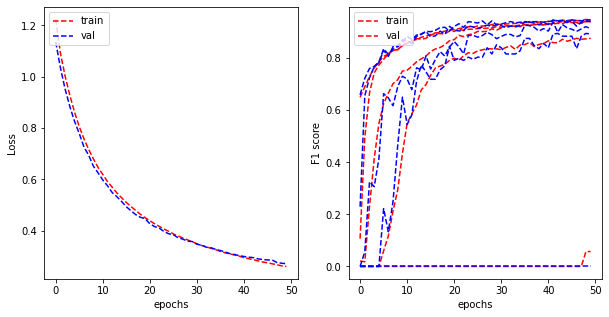

In [409]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['f1_score'], history.history['val_f1_score'], 
                    metric_name='F1 score')

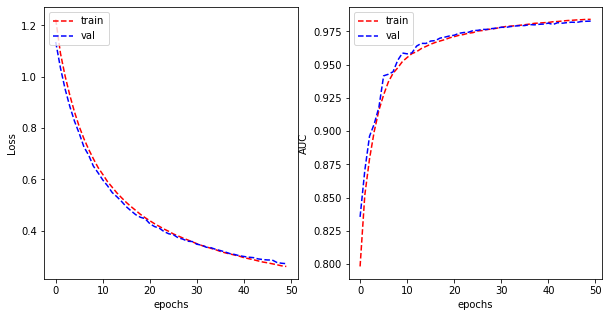

In [410]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['auc_7'], history.history['val_auc_7'], 
                    metric_name='AUC')

From the above plots it can be seen that 
1) The plot of training loss continues to decrease with experience. <br>
2) The plot of validation loss decreases to a point and begins increasing again. <br>
This shows that our model is almost a good fit model but slightly overfitting 

### Incremental model
We want to see the performance of the model with different parmater. Therefore, using activation parameter as 'ReLU'. Additionally, with the Relu parameter, vanishing gradient problem is not seen and it is more efficient to compute than Sigmoid like function since Relu just needs to pick max(0,x) and not perform expensive exponential operations.

In [411]:
warnings.filterwarnings('ignore')
model_relu = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [412]:
model_relu.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=[tfa.metrics.F1Score(num_classes=5), tf.keras.metrics.AUC(from_logits=True) ])

In [413]:
history_relu = model_relu.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)

Epoch 1/50
93/93 [==============================] - 55s 539ms/step - loss: 1.0085 - f1_score: 0.3557 - auc_8: 0.8584 - val_loss: 0.8004 - val_f1_score: 0.3836 - val_auc_8: 0.9060
Epoch 2/50
93/93 [==============================] - 66s 700ms/step - loss: 0.6911 - f1_score: 0.5664 - auc_8: 0.9349 - val_loss: 0.5776 - val_f1_score: 0.6169 - val_auc_8: 0.9533
Epoch 3/50
93/93 [==============================] - 55s 577ms/step - loss: 0.5501 - f1_score: 0.6516 - auc_8: 0.9538 - val_loss: 0.4807 - val_f1_score: 0.6474 - val_auc_8: 0.9616
Epoch 4/50
93/93 [==============================] - 60s 629ms/step - loss: 0.4615 - f1_score: 0.6880 - auc_8: 0.9629 - val_loss: 0.4099 - val_f1_score: 0.7199 - val_auc_8: 0.9714
Epoch 5/50
93/93 [==============================] - 63s 626ms/step - loss: 0.4069 - f1_score: 0.7133 - auc_8: 0.9693 - val_loss: 0.3720 - val_f1_score: 0.7017 - val_auc_8: 0.9736
Epoch 6/50
93/93 [==============================] - 51s 536ms/step - loss: 0.3603 - f1_score: 0.7338 - au

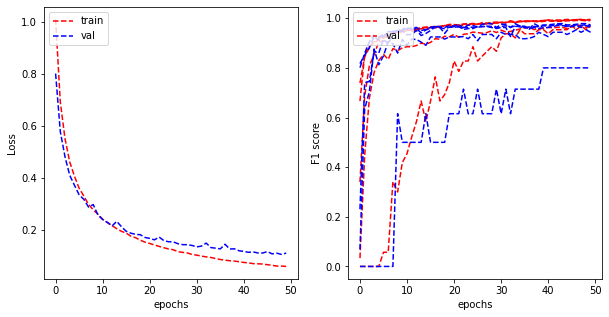

In [414]:
plot_learning_curve(history_relu.history['loss'], history_relu.history['val_loss'], 
                    history_relu.history['f1_score'], history_relu.history['val_f1_score'], 
                    metric_name='F1 score')

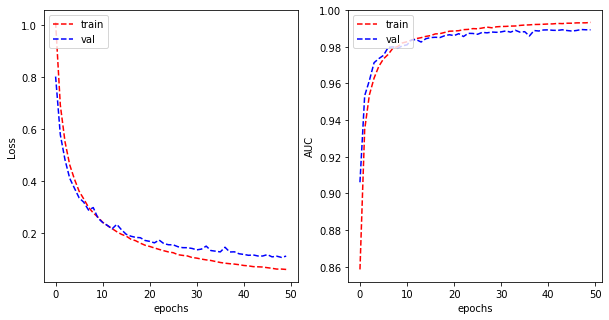

In [415]:
plot_learning_curve(history_relu.history['loss'], history_relu.history['val_loss'], 
                    history_relu.history['auc_8'], history_relu.history['val_auc_8'], 
                    metric_name='AUC')

As infered from the above plots, the model is a good fit with increased f1 score and slightly overfitting, therefore using regularisation technique.
Here we choose the value as 0.01 because values closer to 0 will not penalise the correctly classified lables but will only penalise the wrongly classified labels.

In [416]:
# Ridge regularisation

reg_lambda = 0.01

model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [417]:
model_reg.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tfa.metrics.F1Score(num_classes=5), tf.keras.metrics.AUC(from_logits=True)])

In [418]:
history_reg = model_reg.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)

Epoch 1/50
93/93 [==============================] - 42s 427ms/step - loss: 5.5942 - f1_score: 0.3994 - auc_9: 0.8831 - val_loss: 5.3262 - val_f1_score: 0.6089 - val_auc_9: 0.9351
Epoch 2/50
93/93 [==============================] - 47s 495ms/step - loss: 5.1426 - f1_score: 0.6040 - auc_9: 0.9464 - val_loss: 4.9625 - val_f1_score: 0.6755 - val_auc_9: 0.9571
Epoch 3/50
93/93 [==============================] - 46s 480ms/step - loss: 4.8627 - f1_score: 0.6650 - auc_9: 0.9597 - val_loss: 4.7101 - val_f1_score: 0.6999 - val_auc_9: 0.9702
Epoch 4/50
93/93 [==============================] - 52s 536ms/step - loss: 4.6478 - f1_score: 0.6930 - auc_9: 0.9663 - val_loss: 4.5487 - val_f1_score: 0.7229 - val_auc_9: 0.9667
Epoch 5/50
93/93 [==============================] - 39s 412ms/step - loss: 4.4477 - f1_score: 0.7096 - auc_9: 0.9721 - val_loss: 4.3357 - val_f1_score: 0.7194 - val_auc_9: 0.9763
Epoch 6/50
93/93 [==============================] - 47s 493ms/step - loss: 4.2766 - f1_score: 0.7225 - au

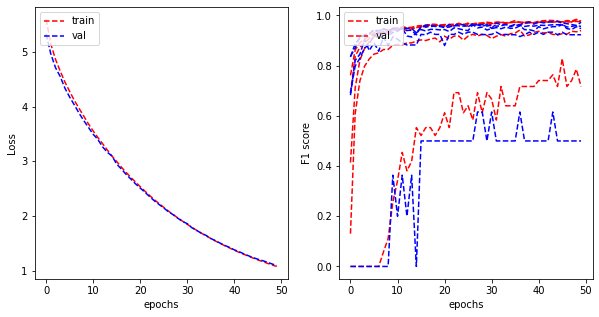

In [419]:
plot_learning_curve(history_reg.history['loss'], history_reg.history['val_loss'], 
                    history_reg.history['f1_score'], history_reg.history['val_f1_score'], 
                    metric_name='F1 score')

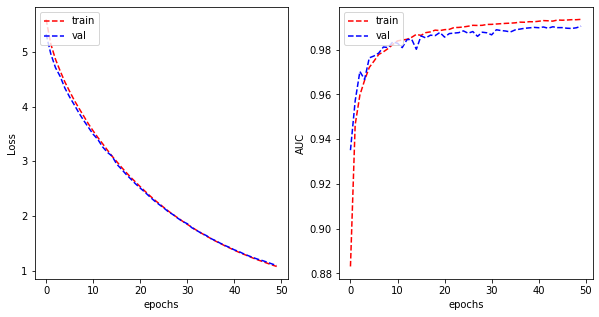

In [420]:
plot_learning_curve(history_reg.history['loss'], history_reg.history['val_loss'], 
                    history_reg.history['auc_9'], history_reg.history['val_auc_9'], 
                    metric_name='AUC')

From the above plot it can be inferred that:
1) The plot of training loss decreases to a point of stability. <br>
2) The plot of validation loss decreases to a point of stability and has a small gap with the training loss.
Therefore it fits the criteria of a `good fit model`. <br>
Since we have obtained a good fit model, we are not doing any further hyper parameter tuning and therefore not employing any dropout mechanisms.

### Base model 3 

#### Convolutional Neural Network (CNN) - Deep Learning model

Both MLP and CNN can be used for Image classification however MLP takes vector as input and CNN takes tensor as input so CNN can understand spatial relation(relation between nearby pixels of image)between pixels of images better. Thus for complicated images CNN will perform better than MLP

In [421]:
train_generator,validation_generator = calculate_generators(train_df, val_df, 'image_path', 'sign_shape_num')

Found 2959 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


We will select the VGG network as our base model. The VGG network was originally designed for classifying large images (with resolution around 224x224). However our images are much smaller (28*28). A block consists of: convolution + activation + pooling). Those blocks will lead to downscaling of the image due to the use of the max pooling layer.

In [422]:
import tensorflow as tf

model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28,28,3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

**Observations** 

- VGG has 3x3 convolution kernels only.
- Pooling is always max-pooling and they are (2x2).
- Padding is same - No boarder pixels lost when applying convolutions.
- activation is ReLULets compile the model and fit.

In [423]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.AUC(from_logits=True), tfa.metrics.F1Score(num_classes=5)])

`Adam` is a replacement optimization algorithm for stochastic gradient descent for training deep learning models. Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.

In [426]:
deep_model = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=30, verbose=1)

Epoch 1/30
93/93 [==============================] - 72s 763ms/step - loss: 6.8151e-07 - auc_10: 0.9528 - f1_score: 1.0000 - val_loss: 0.0490 - val_auc_10: 0.9507 - val_f1_score: 0.9713
Epoch 2/30
93/93 [==============================] - 59s 624ms/step - loss: 6.4328e-07 - auc_10: 0.9528 - f1_score: 1.0000 - val_loss: 0.0495 - val_auc_10: 0.9507 - val_f1_score: 0.9713
Epoch 3/30
93/93 [==============================] - 53s 562ms/step - loss: 6.0513e-07 - auc_10: 0.9527 - f1_score: 1.0000 - val_loss: 0.0497 - val_auc_10: 0.9507 - val_f1_score: 0.9713
Epoch 4/30
93/93 [==============================] - 72s 766ms/step - loss: 5.7049e-07 - auc_10: 0.9526 - f1_score: 1.0000 - val_loss: 0.0497 - val_auc_10: 0.9505 - val_f1_score: 0.9713
Epoch 5/30
93/93 [==============================] - 69s 717ms/step - loss: 5.3721e-07 - auc_10: 0.9527 - f1_score: 1.0000 - val_loss: 0.0500 - val_auc_10: 0.9503 - val_f1_score: 0.9713
Epoch 6/30
93/93 [==============================] - 68s 708ms/step - loss: 

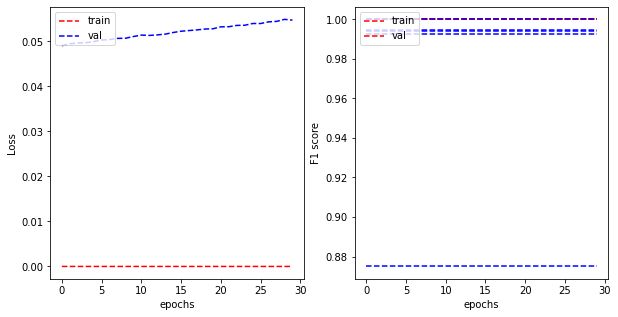

In [427]:
plot_learning_curve(deep_model.history['loss'], deep_model.history['val_loss'], 
                    deep_model.history['f1_score'], deep_model.history['val_f1_score'], 
                    metric_name='F1 score')

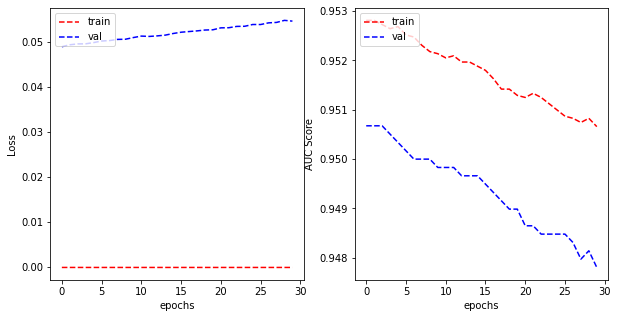

In [429]:
plot_learning_curve(deep_model.history['loss'], deep_model.history['val_loss'], 
                    deep_model.history['auc_10'], deep_model.history['val_auc_10'], 
                    metric_name='AUC Score')

In [ ]:
# Regularistion

In [ ]:
reg_lambda = 0.001

model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(28,28, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [ ]:
model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics= [tf.keras.metrics.AUC(from_logits=True), tfa.metrics.F1Score(num_classes=5)])

In [ ]:
history_VGG_2 = model_VGG_2.fit_generator(train_generator, validation_data = validation_generator, epochs=20, verbose=1)


In [ ]:
plot_learning_curve(history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['f1_score'], history_VGG_2.history['val_f1_score'], 
                    metric_name='Accuracy')

In [ ]:
plot_learning_curve(history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['auc_'], history_VGG_2.history['val_auc'], 
                    metric_name='AUC score')

### Evaluating the model

We have obtained traffic sign images from google (5 per category , 80 in total) and we have reshaped it to match with the given data set(28 x 28). We have also converted it to grey scale and stored it in our directory. Below is the code 

In [85]:
with zipfile.ZipFile('./traffic_signs_evaluation_images_3.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [91]:
image_list = []
for filepath in glob.glob('./traffic_signs_evaluation_images_3/*.png', recursive=True): #Loop through all folders
    filename = filepath.split("\\")[-1]
    sign_shape = filepath.split("\\")[-3]
    
    img_file = Image.open(filepath)
    
    value = np.asarray(img_file, dtype=np.int).reshape((28,28))
    value = value.flatten()

    image_list.append((filepath ,sign_shape, value ))

# Create a data frame
test_shape_data = pd.DataFrame(data=image_list, columns=['image_path', 'sign_shape', 'flattened_array'])

test_image (1).png
test_image (10).png
test_image (11).png
test_image (12).png
test_image (13).png
test_image (14).png
test_image (15).png
test_image (16).png
test_image (17).png
test_image (18).png
test_image (19).png
test_image (2).png
test_image (20).png
test_image (21).png
test_image (22).png
test_image (23).png
test_image (24).png
test_image (25).png
test_image (26).png
test_image (27).png
test_image (28).png
test_image (29).png
test_image (3).png
test_image (30).png
test_image (31).png
test_image (32).png
test_image (33).png
test_image (34).png
test_image (35).png
test_image (36).png
test_image (37).png
test_image (38).png
test_image (39).png
test_image (4).png
test_image (40).png
test_image (41).png
test_image (42).png
test_image (43).png
test_image (44).png
test_image (45).png
test_image (46).png
test_image (47).png
test_image (48).png
test_image (49).png
test_image (5).png
test_image (50).png
test_image (51).png
test_image (52).png
test_image (53).png
test_image (54).png
test_

In [ ]:
test_shape_data['sign_shape_num']= test_shape_data['sign_shape_num'].astype(str)

test_datagen_shape = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_shape_generator = test_datagen_shape.flow_from_dataframe(
        dataframe=test_shape_data,
        directory='./',
        x_col="image_path",
        y_col="sign_shape_num",
        target_size=(28,28),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
model_reg_type.evaluate(test_shape_generator)

In [118]:
# lables = [0, 1, 4]
# testing_data = test_data.loc[0:2]

In [119]:
# testing_data['labels'] = lables

In [121]:
# testing_data['image_path'][0]

'./traffic_signs_evaluation_images\\test_image (1).png'

In [157]:
#df = {'image_path' : data , 'labels' : 3}
# df = {'image_path' : data2 , 'labels' : 2}
# testing_data = testing_data.append(df , ignore_index= True)


In [ ]:
d = {'diamond':0, 'hex':1, 'square':2, 'triangle':3, 'round':4}

1/1 [==============================] - 25s 25s/step
y [1. 0. 0. 0. 0.]
y hat [[-5.4095893  -1.8909748   5.714109    1.7768289   0.85523087]]
Argmax diamond
1/1 [==============================] - 25s 25s/step
y [0. 0. 0. 1. 0.]
y hat [[-4.5072627 -2.7667234  0.8930307  9.770925  -1.3853291]]
Argmax triangle
1/1 [==============================] - 25s 25s/step
y [0. 0. 0. 0. 1.]
y hat [[ 2.691832   -3.306888    0.77235144  0.2304837   2.007558  ]]
Argmax round
1/1 [==============================] - 25s 25s/step
y [0. 1. 0. 0. 0.]
y hat [[ 2.4688053   2.0968516  -5.759761    0.86493284  1.6939458 ]]
Argmax hex
1/1 [==============================] - 24s 24s/step
y [0. 0. 1. 0. 0.]
y hat [[-0.27456924 -3.9889467   1.0406511   4.1077414   0.85767996]]
Argmax square
1/1 [==============================] - 24s 24s/step


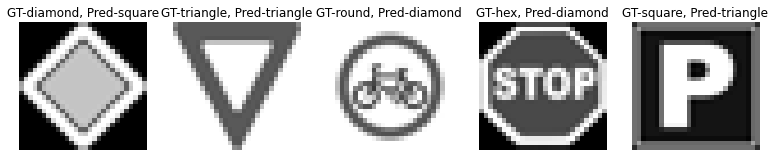

In [165]:
d_inv = {v: k for k, v in d.items()}

plt.figure(figsize=(16,4))
batches = 0
for x,y in test_shape_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=1)
        x = np.squeeze(x)
        if batches < 6:
            plt.subplot(1,6,batches)
            plt.imshow(x)
            print("y", y[0])
            print("y hat", y_hat)
            print("Argmax", d_inv[np.argmax(y[0])])
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

### Classification of Sign - Type

We follow the same set of methodologies to classify the traffic signs based on the sign - type

#### Multi layer perceptron (MLP) - Neural network model

In [200]:
# specifying the parameters 
INPUT_DIM = (28,28,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 16

In [201]:
# Based on the previous model peformance we choose 'relu' to be our activation function for the reasons mentioned previosuly

warnings.filterwarnings('ignore')
model_sign_type = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [202]:
model_sign_type.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 2352)              0         
                                                                 
 dense_10 (Dense)            (None, 256)               602368    
                                                                 
 dense_11 (Dense)            (None, 16)                4112      
                                                                 
Total params: 606,480
Trainable params: 606,480
Non-trainable params: 0
_________________________________________________________________


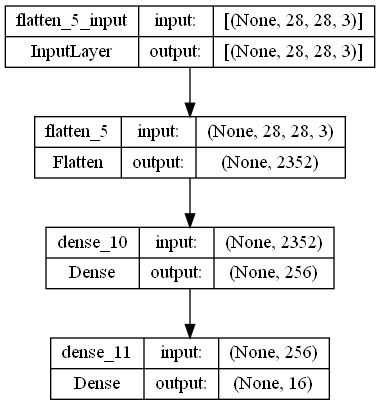

In [203]:
tf.keras.utils.plot_model(model_sign_type, show_shapes=True)

In [213]:
model_sign_type.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=[tfa.metrics.F1Score(num_classes=16), tf.keras.metrics.AUC(from_logits=True)])

In [177]:
train_x.to_frame()

,image_path
2188,./trafficsigns_dataset\square\continue\01290_0...
2034,./trafficsigns_dataset\round\traveldirection\0...
845,./trafficsigns_dataset\round\noentry\00936_000...
2473,./trafficsigns_dataset\square\laneend\01497_00...
2277,./trafficsigns_dataset\square\continue\01707_0...
...,...
2547,./trafficsigns_dataset\square\parking\00115_00...
919,./trafficsigns_dataset\round\noentry\01084_000...
1457,./trafficsigns_dataset\round\speed\00028_00001...
3014,./trafficsigns_dataset\triangle\warning\00014_...


#### Data split
We choose to split the data into train and validation having 80:20 data points.  

In [205]:
train_x, val_x, train_y, val_y = train_test_split(data['image_path'], data['sign_type_num'], test_size=0.2, stratify=data['sign_type_num'])

In [206]:
train_df = pd.DataFrame()
train_df['image_path']=train_x.to_frame()
train_df['sign_type_num']=train_y.to_frame()

In [207]:
val_df = pd.DataFrame()
val_df['image_path']=val_x.to_frame()
val_df['sign_type_num']=val_y.to_frame()

In [208]:
train_df.head()

,image_path,sign_type_num
1403,./trafficsigns_dataset\round\roundabout\01311_...,6
2416,./trafficsigns_dataset\square\laneend\00449_00...,12
2086,./trafficsigns_dataset\square\continue\00093_0...,10
1885,./trafficsigns_dataset\round\trafficdirective\...,8
1478,./trafficsigns_dataset\round\speed\00377_00001...,7


In [209]:
val_df.head()

,image_path,sign_type_num
2216,./trafficsigns_dataset\square\continue\01499_0...,10
2745,./trafficsigns_dataset\square\parking\01596_00...,13
1939,./trafficsigns_dataset\round\trafficdirective\...,8
3283,./trafficsigns_dataset\triangle\warning\00675_...,15
2906,./trafficsigns_dataset\triangle\giveway\01190_...,14


In [210]:
train_df['sign_type_num']=train_df['sign_type_num'].astype(str)
val_df['sign_type_num']=val_df['sign_type_num'].astype(str)


Found 2959 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


In [ ]:
train_generator,validation_generator = calculate_generators(train_df, val_df, 'image_path', 'sign_type_num')

Note: Since the methodology for the classification of sign- type is similar to the classification of sign- shape we have reduced the epochs from 50 to 30. Another reason to make this change is that it consumes lot of time to execute the code.

In [214]:
history_type = model_sign_type.fit_generator(train_generator, validation_data = validation_generator, epochs=30, verbose=1)

Epoch 1/5
93/93 [==============================] - 42s 416ms/step - loss: 1.1151 - f1_score: 0.5425 - auc: 0.9542 - val_loss: 1.1074 - val_f1_score: 0.5515 - val_auc: 0.9520
Epoch 2/5
93/93 [==============================] - 53s 535ms/step - loss: 1.0755 - f1_score: 0.5716 - auc: 0.9565 - val_loss: 1.0712 - val_f1_score: 0.5681 - val_auc: 0.9526
Epoch 3/5
93/93 [==============================] - 37s 386ms/step - loss: 1.0384 - f1_score: 0.5865 - auc: 0.9575 - val_loss: 1.0366 - val_f1_score: 0.5867 - val_auc: 0.9551
Epoch 4/5
93/93 [==============================] - 39s 408ms/step - loss: 1.0030 - f1_score: 0.6079 - auc: 0.9589 - val_loss: 1.0058 - val_f1_score: 0.6387 - val_auc: 0.9574
Epoch 5/5
93/93 [==============================] - 43s 454ms/step - loss: 0.9714 - f1_score: 0.6314 - auc: 0.9608 - val_loss: 0.9776 - val_f1_score: 0.6423 - val_auc: 0.9576


In [ ]:
# Need to tune the parameters to obtain better results because of the presence of 16 class labels.

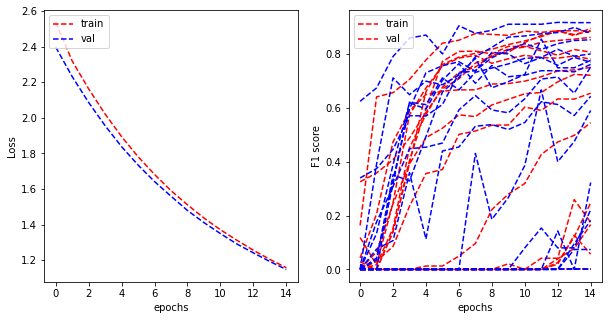

In [212]:
plot_learning_curve(history_type.history['loss'], history_type.history['val_loss'], 
                    history_type.history['f1_score'], history_type.history['val_f1_score'], 
                    metric_name='F1 score')

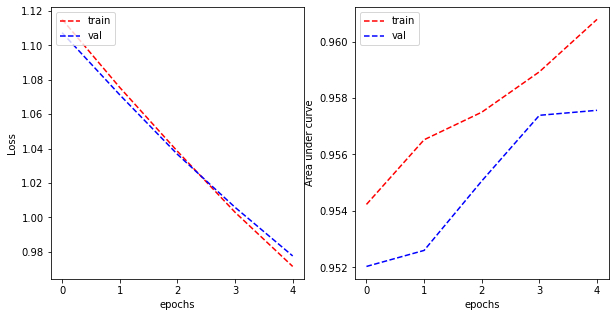

In [215]:
plot_learning_curve(history_type.history['loss'], history_type.history['val_loss'], 
                    history_type.history['auc'], history_type.history['val_auc'], 
                    metric_name='AUC')

In [219]:
# Regularisation
# Ridge regularisation

reg_lambda = 0.01

model_reg_type = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [222]:
model_reg_type.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tfa.metrics.F1Score(num_classes= 16), tf.keras.metrics.AUC(from_logits=True)])

In [223]:
history_reg_type = model_reg_type.fit_generator(train_generator, validation_data = validation_generator, epochs= 30, verbose=1)

Epoch 1/15
93/93 [==============================] - 46s 469ms/step - loss: 7.3614 - f1_score: 0.0333 - auc_3: 0.6911 - val_loss: 7.1602 - val_f1_score: 0.0399 - val_auc_3: 0.7429
Epoch 2/15
93/93 [==============================] - 33s 342ms/step - loss: 7.0085 - f1_score: 0.0518 - auc_3: 0.7647 - val_loss: 6.8484 - val_f1_score: 0.0823 - val_auc_3: 0.7953
Epoch 3/15
93/93 [==============================] - 34s 357ms/step - loss: 6.7116 - f1_score: 0.1039 - auc_3: 0.8079 - val_loss: 6.5615 - val_f1_score: 0.1123 - val_auc_3: 0.8291
Epoch 4/15
93/93 [==============================] - 32s 337ms/step - loss: 6.4366 - f1_score: 0.1772 - auc_3: 0.8380 - val_loss: 6.3063 - val_f1_score: 0.2328 - val_auc_3: 0.8456
Epoch 5/15
93/93 [==============================] - 32s 339ms/step - loss: 6.1880 - f1_score: 0.2595 - auc_3: 0.8577 - val_loss: 6.0655 - val_f1_score: 0.3299 - val_auc_3: 0.8704
Epoch 6/15
93/93 [==============================] - 35s 362ms/step - loss: 5.9579 - f1_score: 0.3231 - au

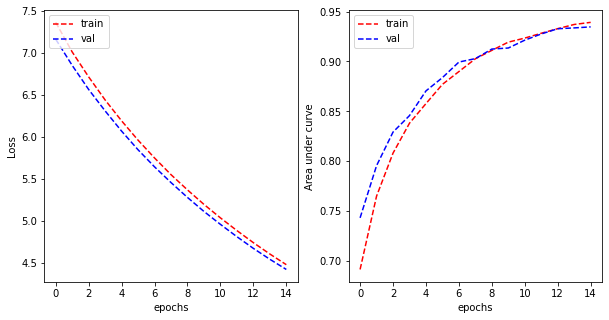

In [226]:
# good model
plot_learning_curve(history_reg_type.history['loss'], history_reg_type.history['val_loss'], 
                    history_reg_type.history['auc_3'], history_reg_type.history['val_auc_3'], 
                    metric_name='AUC')

In [228]:
# Dropout 
reg_lambda = 0.01

model_drop_type = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [229]:
model_drop_type.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tfa.metrics.F1Score(num_classes=16), tf.keras.metrics.AUC(from_logits=True)])

In [230]:
history_drop_type = model_drop_type.fit_generator(train_generator, validation_data = validation_generator, epochs=30, verbose=1)

Epoch 1/15
93/93 [==============================] - 91s 908ms/step - loss: 2.6316 - f1_score: 0.0596 - auc_4: 0.6568 - val_loss: 2.4236 - val_f1_score: 0.0425 - val_auc_4: 0.7585
Epoch 2/15
93/93 [==============================] - 79s 820ms/step - loss: 2.4312 - f1_score: 0.0953 - auc_4: 0.7251 - val_loss: 2.2784 - val_f1_score: 0.1217 - val_auc_4: 0.7994
Epoch 3/15
93/93 [==============================] - 80s 831ms/step - loss: 2.2814 - f1_score: 0.1447 - auc_4: 0.7699 - val_loss: 2.1356 - val_f1_score: 0.2373 - val_auc_4: 0.8346
Epoch 4/15
93/93 [==============================] - 83s 865ms/step - loss: 2.1543 - f1_score: 0.2076 - auc_4: 0.8009 - val_loss: 2.0081 - val_f1_score: 0.2643 - val_auc_4: 0.8564
Epoch 5/15
93/93 [==============================] - 81s 843ms/step - loss: 2.0234 - f1_score: 0.2450 - auc_4: 0.8300 - val_loss: 1.8945 - val_f1_score: 0.3331 - val_auc_4: 0.8785
Epoch 6/15
93/93 [==============================] - 80s 826ms/step - loss: 1.9187 - f1_score: 0.2822 - au

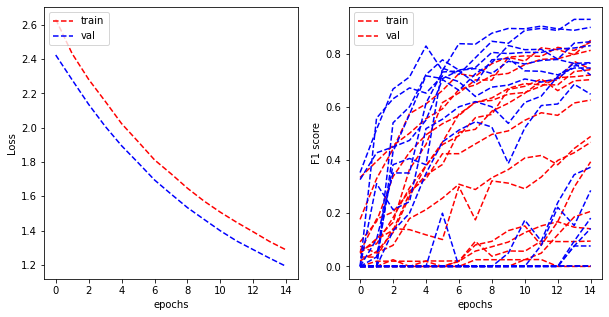

In [231]:
plot_learning_curve(history_drop_type.history['loss'], history_drop_type.history['val_loss'], 
                    history_drop_type.history['f1_score'], history_drop_type.history['val_f1_score'], 
                    metric_name='F1 score')

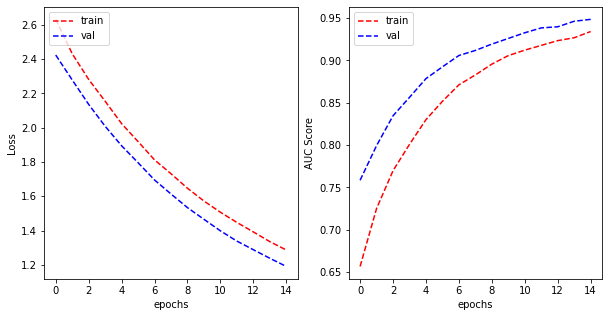

In [232]:
plot_learning_curve(history_drop_type.history['loss'], history_drop_type.history['val_loss'], 
                    history_drop_type.history['auc_4'], history_drop_type.history['val_auc_4'], 
                    metric_name='AUC Score')

In [ ]:
# Deep learning

In [233]:
import tensorflow as tf


model_VGG_type = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28,28,3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [234]:
model_VGG_type.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tfa.metrics.F1Score(num_classes=16), tf.keras.metrics.AUC(from_logits=True)])

In [235]:
train_generator,validation_generator = calculate_generators(train_df, val_df, 'image_path', 'sign_type_num')

Found 2959 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


In [236]:
history_VGG_type = model_VGG_type.fit_generator(train_generator, validation_data = validation_generator, epochs=30, verbose=1)

Epoch 1/15
93/93 [==============================] - 96s 953ms/step - loss: 1.4399 - f1_score: 0.4944 - auc_5: 0.8271 - val_loss: 0.4266 - val_f1_score: 0.8615 - val_auc_5: 0.9381
Epoch 2/15
93/93 [==============================] - 87s 902ms/step - loss: 0.2946 - f1_score: 0.8968 - auc_5: 0.9386 - val_loss: 0.2934 - val_f1_score: 0.9146 - val_auc_5: 0.9392
Epoch 3/15
93/93 [==============================] - 88s 914ms/step - loss: 0.1374 - f1_score: 0.9522 - auc_5: 0.9422 - val_loss: 0.1155 - val_f1_score: 0.9692 - val_auc_5: 0.9330
Epoch 4/15
93/93 [==============================] - 89s 925ms/step - loss: 0.0702 - f1_score: 0.9698 - auc_5: 0.9349 - val_loss: 0.1518 - val_f1_score: 0.9564 - val_auc_5: 0.9165
Epoch 5/15
93/93 [==============================] - 88s 917ms/step - loss: 0.0530 - f1_score: 0.9787 - auc_5: 0.9325 - val_loss: 0.0841 - val_f1_score: 0.9678 - val_auc_5: 0.9322
Epoch 6/15
93/93 [==============================] - 88s 904ms/step - loss: 0.0403 - f1_score: 0.9830 - au

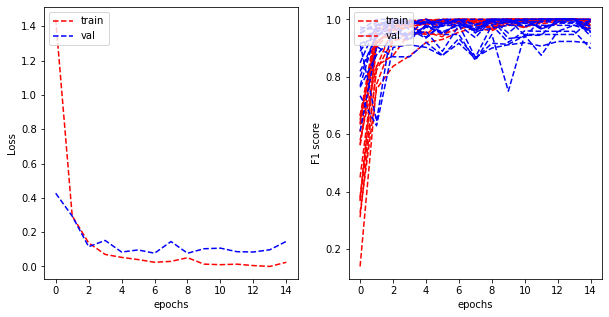

In [237]:
plot_learning_curve(history_VGG_type.history['loss'], history_VGG_type.history['val_loss'], 
                    history_VGG_type.history['f1_score'], history_VGG_type.history['val_f1_score'], 
                    metric_name='F1 score')

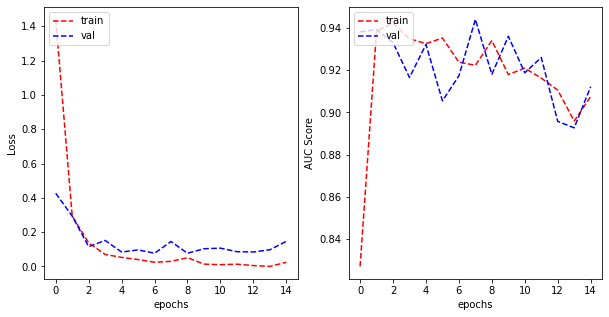

In [238]:
plot_learning_curve(history_VGG_type.history['loss'], history_VGG_type.history['val_loss'], 
                    history_VGG_type.history['auc_5'], history_VGG_type.history['val_auc_5'], 
                    metric_name='AUC Score')

**Observations**

1) The plot of training loss continues to decrease with experience. <br>
2) The plot of validation loss decreases to a point and begins increasing again. <br>

In [239]:
#Regularisation
#weights close to zero have little effect on model complexity, while outlier weights can have a huge impact.

reg_lambda = 0.001

model_VGG_type2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(28,28, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [240]:
model_VGG_type2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tfa.metrics.F1Score(num_classes=16), tf.keras.metrics.AUC(from_logits=True)])

In [241]:
train_generator,validation_generator = calculate_generators(train_df, val_df, 'image_path', 'sign_type_num')

Found 2959 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


In [242]:
history_VGG_type2 = model_VGG_type2.fit_generator(train_generator, validation_data = validation_generator, epochs=30, verbose=1)

Epoch 1/15
93/93 [==============================] - 48s 471ms/step - loss: 2.1186 - f1_score: 0.2949 - auc_6: 0.7903 - val_loss: 0.7995 - val_f1_score: 0.6849 - val_auc_6: 0.9512
Epoch 2/15
93/93 [==============================] - 39s 412ms/step - loss: 0.6357 - f1_score: 0.8205 - auc_6: 0.9519 - val_loss: 0.4186 - val_f1_score: 0.9168 - val_auc_6: 0.9740
Epoch 3/15
93/93 [==============================] - 39s 409ms/step - loss: 0.3893 - f1_score: 0.9157 - auc_6: 0.9635 - val_loss: 0.3492 - val_f1_score: 0.9412 - val_auc_6: 0.9690
Epoch 4/15
93/93 [==============================] - 37s 391ms/step - loss: 0.2953 - f1_score: 0.9515 - auc_6: 0.9624 - val_loss: 0.2947 - val_f1_score: 0.9608 - val_auc_6: 0.9640
Epoch 5/15
93/93 [==============================] - 37s 381ms/step - loss: 0.2568 - f1_score: 0.9647 - auc_6: 0.9578 - val_loss: 0.2819 - val_f1_score: 0.9497 - val_auc_6: 0.9749
Epoch 6/15
93/93 [==============================] - 37s 386ms/step - loss: 0.2421 - f1_score: 0.9698 - au

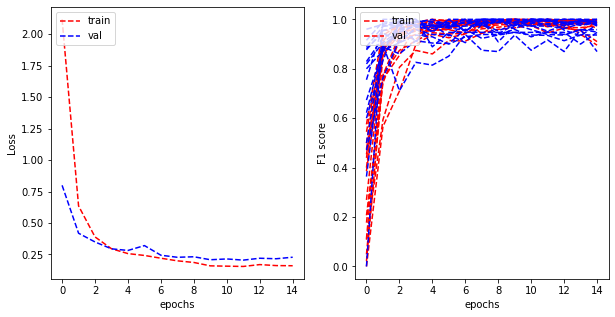

In [243]:
plot_learning_curve(history_VGG_type2.history['loss'], history_VGG_type2.history['val_loss'], 
                    history_VGG_type2.history['f1_score'], history_VGG_type2.history['val_f1_score'], 
                    metric_name='F1 score')

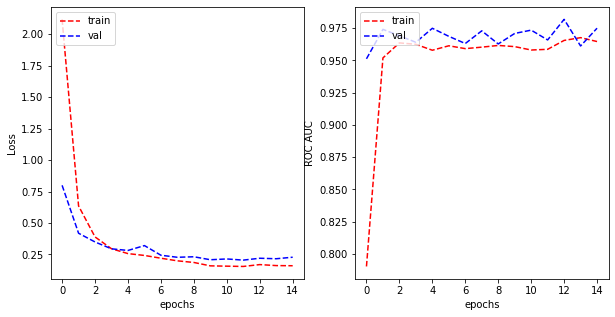

In [244]:
plot_learning_curve(history_VGG_type2.history['loss'], history_VGG_type2.history['val_loss'], 
                    history_VGG_type2.history['auc_6'], history_VGG_type2.history['val_auc_6'], 
                    metric_name='ROC AUC')

#### Evaluating the sign- type

In [335]:
image_list = []
for filepath in glob.glob('./traffic_signs_evaluation_images_3/*/*/*.png', recursive=True): #Loop through all folders
    filename = filepath.split("\\")[-1]
    sign_type = filepath.split("\\")[-2]    
    sign_shape = filepath.split("\\")[-3]
    img_file = Image.open(filepath)
    
    value = np.asarray(img_file, dtype=np.int).reshape((28,28))
    value = value.flatten()

    image_list.append((filepath,sign_type, value ))

# Create a data frame
test_data = pd.DataFrame(data=image_list, columns=['image_path', 'sign_type', 'flattened_array'])

In [336]:
test_data.head()

,image_path,sign_type,flattened_array
0,./traffic_signs_evaluation_images_3\diamond\ri...,rightofway,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 160, ..."
1,./traffic_signs_evaluation_images_3\diamond\ri...,rightofway,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
2,./traffic_signs_evaluation_images_3\diamond\ri...,rightofway,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 40, 132, ..."
3,./traffic_signs_evaluation_images_3\diamond\ri...,rightofway,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 96, 96..."
4,./traffic_signs_evaluation_images_3\diamond\ri...,rightofway,"[221, 226, 227, 227, 228, 230, 230, 230, 230, ..."


In [337]:
test_data['flattened_array'] = test_data['flattened_array']/255.0

In [338]:
test_data.tail()

,image_path,sign_type,flattened_array
75,./traffic_signs_evaluation_images_3\triangle\w...,warning,"[0.9686274509803922, 0.9647058823529412, 0.960..."
76,./traffic_signs_evaluation_images_3\triangle\w...,warning,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
77,./traffic_signs_evaluation_images_3\triangle\w...,warning,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
78,./traffic_signs_evaluation_images_3\triangle\w...,warning,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
79,./traffic_signs_evaluation_images_3\triangle\w...,warning,"[0.9647058823529412, 0.9647058823529412, 0.964..."


In [271]:
d1 = {'rightofway':0, 'stop':1, 'bicycle':2, 'limitedtraffic':3, 'noentry':4, 'noparking':5, 'roundabout':6, 'speed':7, 'trafficdirective':8, 'traveldirection':9,  'continue':10, 'crossing':11, 'laneend':12, 'parking':13, 'giveway':14, 'warning':15}
test_data['sign_type_num'] = test_data['sign_type'].map(d1, na_action='ignore')

In [272]:
test_data.head()

,image_path,sign_type,sign_type_num
0,./traffic_signs_evaluation_images_3\diamond\ri...,rightofway,0
1,./traffic_signs_evaluation_images_3\diamond\ri...,rightofway,0
2,./traffic_signs_evaluation_images_3\diamond\ri...,rightofway,0
3,./traffic_signs_evaluation_images_3\diamond\ri...,rightofway,0
4,./traffic_signs_evaluation_images_3\diamond\ri...,rightofway,0


In [273]:
testing_type_data = test_data[['image_path', 'sign_type_num']]
testing_type_data.head()

,image_path,sign_type_num
0,./traffic_signs_evaluation_images_3\diamond\ri...,0
1,./traffic_signs_evaluation_images_3\diamond\ri...,0
2,./traffic_signs_evaluation_images_3\diamond\ri...,0
3,./traffic_signs_evaluation_images_3\diamond\ri...,0
4,./traffic_signs_evaluation_images_3\diamond\ri...,0


In [257]:
# score = model_reg_type.evaluate(test_data['image_path'], test_data['sign_type'], verbose = 1)
# print('Test Score', score[0])
# print('Test Accuracy', score[1])

In [312]:
testing_type_data['sign_type_num']= testing_type_data['sign_type_num'].astype(str)

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory='./',
        x_col="image_path",
        y_col="sign_type_num",
        target_size=(28,28),
        batch_size=batch_size,
        class_mode='categorical')

Found 740 validated image filenames belonging to 16 classes.


In [275]:
# Neural network model
model_reg_type.evaluate(test_generator)

80/80 [==============================] - 20s 8ms/step - loss: 5.4823 - f1_score: 0.2189 - auc_3: 0.7167


[5.482284069061279,
 array([0.        , 0.        , 0.22222224, 0.        , 0.        ,
        0.88888896, 0.7692308 , 0.33333334, 0.23076925, 0.        ,
        0.5       , 0.25      , 0.        , 0.30769232, 0.        ,
        0.        ], dtype=float32),
 0.7167396545410156]

In [276]:
# Deep learning model 
model_VGG_type2.evaluate(test_generator)

80/80 [==============================] - 21s 8ms/step - loss: 3.5868 - f1_score: 0.6525 - auc_6: 0.9281


[3.5868027210235596,
 array([0.52631575, 0.90909094, 0.5       , 0.        , 0.5714286 ,
        0.88888896, 1.        , 0.52631575, 0.2857143 , 0.5714286 ,
        0.8000001 , 0.88888896, 0.75      , 0.88888896, 0.6666667 ,
        0.6666667 ], dtype=float32),
 0.9280833601951599]

In [ ]:
testing_ty

In [264]:
d1

{'rightofway': 0,
 'stop': 1,
 'bicycle': 2,
 'limitedtraffic': 3,
 'noentry': 4,
 'noparking': 5,
 'roundabout': 6,
 'speed': 7,
 'trafficdirective': 8,
 'traveldirection': 9,
 'continue': 10,
 'crossing': 11,
 'laneend': 12,
 'parking': 13,
 'giveway': 14,
 'warning': 15}

In [284]:
one = t['image_path'][20]

In [ ]:
testing_data['image_path'][0]

In [303]:
random = testing_type_data.sample(5)


In [341]:
img = test_data.loc[78]['flattened_array']

In [344]:
img.shape

(784,)

In [295]:
r_inx = np.random.choice(80, 5)
rand_data = pd.DataFrame(testing_type_data.loc[r_inx,'image_path'])
#rand_data = pd.DataFrame(testing_type_data.loc['image_path'][r_inx])

# plt.figure(figsize=(16,4))
# for i, image_path in enumerate(rand_data):
#     im = np.asarray(Image.open(image_path))
#     plt.subplot(1,4,i+1)
#     plt.imshow(im,cmap='gray')
#     plt.axis('off')
    
# plt.show()

In [304]:
random.head(20)

,image_path,sign_type_num
78,./traffic_signs_evaluation_images_3\triangle\w...,15
13,./traffic_signs_evaluation_images_3\round\bicy...,2
24,./traffic_signs_evaluation_images_3\round\noen...,4
62,./traffic_signs_evaluation_images_3\square\lan...,12
65,./traffic_signs_evaluation_images_3\square\par...,13


In [308]:
type(test_generator)

keras.preprocessing.image.DataFrameIterator

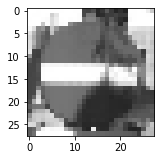

continue
1/1 [==============================] - 25s 25s/step
y_hat  continue


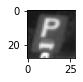

noparking
1/1 [==============================] - 26s 26s/step
y_hat  noparking


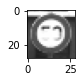

parking
1/1 [==============================] - 25s 25s/step
y_hat  parking


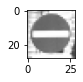

continue
1/1 [==============================] - 25s 25s/step
y_hat  continue


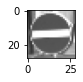

continue
1/1 [==============================] - 25s 25s/step
y_hat  continue


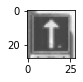

bicycle
1/1 [==============================] - 25s 25s/step
y_hat  bicycle


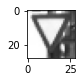

roundabout
1/1 [==============================] - 24s 24s/step
y_hat  roundabout


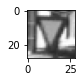

roundabout
1/1 [==============================] - 25s 25s/step
y_hat  roundabout


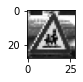

speed
1/1 [==============================] - 26s 26s/step
y_hat  speed


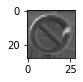

crossing
1/1 [==============================] - 25s 25s/step
y_hat  crossing


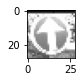

warning
1/1 [==============================] - 25s 25s/step
y_hat  trafficdirective


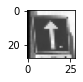

bicycle
1/1 [==============================] - 26s 26s/step
y_hat  bicycle


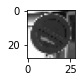

crossing
1/1 [==============================] - 26s 26s/step
y_hat  crossing


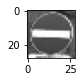

continue
1/1 [==============================] - 25s 25s/step
y_hat  continue


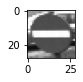

continue
1/1 [==============================] - 25s 25s/step
y_hat  continue


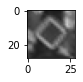

rightofway
1/1 [==============================] - 26s 26s/step
y_hat  rightofway


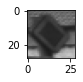

rightofway


KeyboardInterrupt: 

In [327]:
d_inv = {v: k for k, v in d1.items()}

plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
    a=x
    x = np.squeeze(x)
    print(x.)
    plt.subplot(1,6,1)
    plt.imshow(x)
    plt.show()
    print(d_inv[np.argmax(y[0])])
    
    batches = batches + 1
    y_hat = model_VGG_type2.predict(a, verbose=1)
    print("y_hat ",d_inv[np.argmax(y_hat[0])])
    
#     x = np.squeeze(x)
#     if batches < 6:
#         plt.subplot(1,6,batches)
#         plt.imshow(x) 
#         plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
#     else:
#         break
        
    plt.axis('off')

In [346]:
prediction = model_VGG_type2.predict(img)

prediction

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_11/conv2d_6/Relu' defined at (most recent call last):
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\asyncio\base_events.py", line 541, in run_forever
      self._run_once()
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\asyncio\base_events.py", line 1786, in _run_once
      handle._run()
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\IPython\core\interactiveshell.py", line 2915, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3186, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\supri\AppData\Local\Temp\ipykernel_12180\2603743549.py", line 9, in <module>
      y_hat = model_VGG_type2.predict(x, verbose=1)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\keras\engine\training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\keras\engine\training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\keras\engine\training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\keras\engine\training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
      return self(x, training=False)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\keras\engine\functional.py", line 459, in call
      inputs, training=training, mask=mask)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\keras\layers\convolutional\base_conv.py", line 278, in call
      return self.activation(outputs)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\keras\activations.py", line 311, in relu
      return backend.relu(x, alpha=alpha, max_value=max_value, threshold=threshold)
    File "C:\Users\supri\anaconda3\envs\tensorflowEnv\lib\site-packages\keras\backend.py", line 4992, in relu
      x = tf.nn.relu(x)
Node: 'sequential_11/conv2d_6/Relu'
input must be 4-dimensional[32]
	 [[{{node sequential_11/conv2d_6/Relu}}]] [Op:__inference_predict_function_159452]

## Ultimate Judgement

**Final performance for Sign - Shape**

| Model | Training F1-Score | Validation F1-Score | 
| :- | :-: | :-: |
| Logistic regression - Baseline  | 0.734 | 0.726 | 
| Logistic regression - Regularised |
| MLP -Neural Network - Baseline | 0.750 | 0.774 |
| MLP -Neural Network - Incremental | 0.750 | 0.774 |
| MLP -Neural Network - Regularised | 0.750 | 0.774 |
| CNN -Deep Learning - Baseline | 0.750 | 0.774 |
| CNN -Deep Learning - Regularised | 0.750 | 0.774 |

**Final performance for Sign - Type**

| Model | Training F1-Score | Validation F1-Score | 
| :- | :-: | :-: |
| Logistic regression - Baseline  | 0.734 | 0.726 | 
| Logistic regression - Regularised |
| MLP -Neural Network - Baseline | 0.750 | 0.774 |
| MLP -Neural Network - Regularised | 0.750 | 0.774 |
| CNN -Deep Learning - Baseline | 0.750 | 0.774 |
| CNN -Deep Learning - Regularised | 0.750 | 0.774 |
Now lets compare the performance of all the classifiers

